# Task 1: Statevector Simulation of Quantum Circuits 

## 1) Naive simulation using matrix multiplication
I just create a very simple circuit here just to test out the things

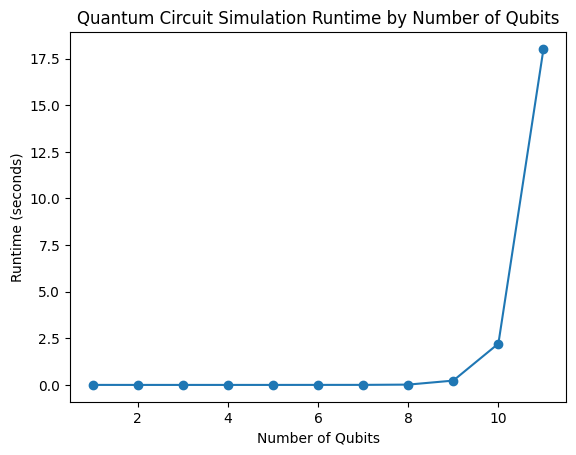

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Define basic quantum gates
def pauli_x():
    return np.array([[0, 1], [1, 0]])

def hadamard():
    return (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]])

def cnot():
    return np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0]
    ])

# Function to initialize n-qubit state vector to |0⟩
def initialize_state(n):
    state = np.zeros(2 ** n, dtype=complex)
    state[0] = 1  # Start in the |0⟩...|0⟩ state
    return state

# Function to apply a single qubit gate to qubit k in an n-qubit system
def apply_single_qubit_gate(gate, state, qubit, n):
    full_gate = 1
    for i in range(n):
        if i == qubit:
            full_gate = np.kron(full_gate, gate)
        else:
            full_gate = np.kron(full_gate, np.eye(2))
    return full_gate @ state

# Function to apply CNOT gate to control and target qubits in an n-qubit system
def apply_cnot(state, control, target, n):

    # Construct the full CNOT gate for the n-qubit system
    full_gate = 0
    # Loop over all possible binary states of n qubits
    for i in range(2**n):
        # Convert integer index to binary (current state of all qubits)
        bits = [(i >> bit) & 1 for bit in range(n)][::-1]
        # If control qubit is 1, swap the target bit
        if bits[control] == 1:
            bits[target] ^= 1  # Flip the target bit
        # Convert modified binary back to integer
        j = int("".join(map(str, bits)), 2)
        # Add to full gate
        full_gate += np.outer(np.eye(2**n)[j], np.eye(2**n)[i])
    return full_gate @ state

# Simulate a quantum circuit
def simulate_circuit(n):
    # Initialize state
    state = initialize_state(n)
    
    # Apply gates (example sequence: Hadamard on qubit 0, CNOT with control=0, target=1)
    state = apply_single_qubit_gate(hadamard(), state, 0, n)
    if n > 1:
        state = apply_cnot(state, 0, 1, n)
    
    return state

# Measure runtime for different qubit numbers
def measure_runtime(max_qubits):
    runtimes = []
    qubit_counts = range(1, max_qubits + 1)
    
    for n in qubit_counts:
        start_time = time.time()
        _ = simulate_circuit(n)
        end_time = time.time()
        runtimes.append(end_time - start_time)
    
    return qubit_counts, runtimes

# Plot runtime as a function of the number of qubits
max_qubits = 11
qubit_counts, runtimes = measure_runtime(max_qubits)

plt.plot(qubit_counts, runtimes, marker='o')
plt.xlabel("Number of Qubits")
plt.ylabel("Runtime (seconds)")
plt.title("Quantum Circuit Simulation Runtime by Number of Qubits")
plt.show()


## 2)  Advanced simulation using tensor multiplication
Same thing with the tensor multiplication

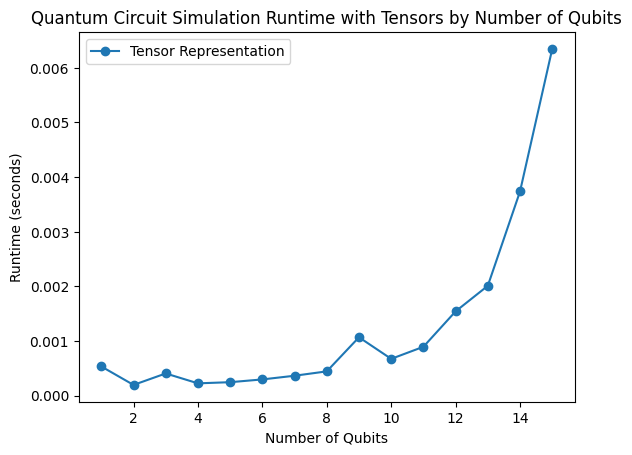

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Define basic quantum gates as numpy arrays
def pauli_x():
    return np.array([[0, 1], [1, 0]])

def hadamard():
    return (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]])

def cnot():
    return np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0]
    ]).reshape(2, 2, 2, 2)

# Initialize n-qubit state tensor in |0...0⟩
def initialize_state_tensor(n):
    state = np.zeros([2] * n, dtype=complex)
    state[(0,) * n] = 1  # Set the |0⟩...|0⟩ state
    return state

# Apply a single-qubit gate to a specified qubit axis in an n-qubit tensor
def apply_single_qubit_gate_tensor(state, gate, qubit, n):
    # Use tensordot to apply the gate along the qubit axis
    axes = ([1], [qubit])
    state = np.tensordot(gate, state, axes=axes)
    # Move the axis to its original position
    state = np.moveaxis(state, 0, qubit)
    return state

# Apply a CNOT gate to control and target qubits in an n-qubit tensor
def apply_cnot_tensor(state, control, target, n):
    # Use tensordot to apply the CNOT gate along the specified axes
    state = np.tensordot(cnot(), state, axes=([2, 3], [control, target]))
    # Rearrange axes to maintain original order
    permute = list(range(n))
    permute.remove(control)
    permute.remove(target)
    permute = [control, target] + permute
    state = np.transpose(state, permute)
    return state

# Generate a quantum circuit for n qubits
def generate_circuit_tensor(n):
    state = initialize_state_tensor(n)
    
    # Apply Hadamard to each qubit
    for qubit in range(n):
        state = apply_single_qubit_gate_tensor(state, hadamard(), qubit, n)
    
    # Apply CNOT between adjacent qubits
    for qubit in range(n - 1):
        state = apply_cnot_tensor(state, qubit, qubit + 1, n)
    
    return state

# Measure runtime for different qubit numbers
def measure_runtime_tensor(max_qubits):
    runtimes = []
    qubit_counts = range(1, max_qubits + 1)
    
    for n in qubit_counts:
        start_time = time.time()
        _ = generate_circuit_tensor(n)
        end_time = time.time()
        runtimes.append(end_time - start_time)
    
    return qubit_counts, runtimes

# Plot runtime as a function of the number of qubits
max_qubits = 15
qubit_counts, runtimes = measure_runtime_tensor(max_qubits)

plt.plot(qubit_counts, runtimes, marker='o', label="Tensor Representation")
plt.xlabel("Number of Qubits")
plt.ylabel("Runtime (seconds)")
plt.title("Quantum Circuit Simulation Runtime with Tensors by Number of Qubits")
plt.legend()
plt.show()


## Combined Implimentation
Here I plot the runtime in the same graph for camparision. The circuit used this time was GHZ.

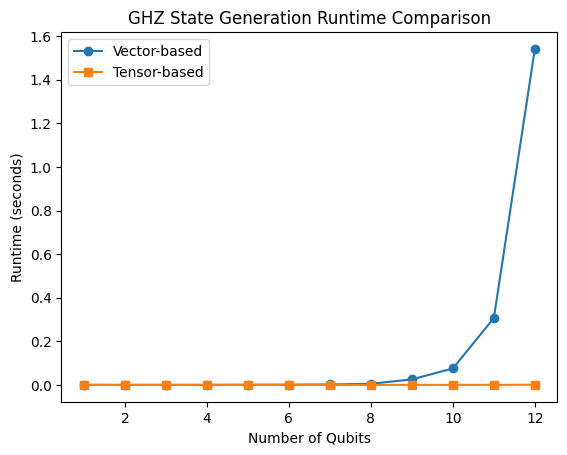

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Define basic quantum gates
def pauli_x():
    return np.array([[0, 1], [1, 0]])

def hadamard():
    return (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]])

def cnot():
    return np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0]
    ])

# Initialize n-qubit state in vector representation for |0...0⟩
def initialize_state(n):
    state = np.zeros(2 ** n, dtype=complex)
    state[0] = 1  # Start in the |0⟩...|0⟩ state
    return state

# Apply a single-qubit gate to a specified qubit in an n-qubit system (vector-based)
def apply_single_qubit_gate_vector(gate, state, qubit, n):
    full_gate = 1
    for i in range(n):
        if i == qubit:
            full_gate = np.kron(full_gate, gate)
        else:
            full_gate = np.kron(full_gate, np.eye(2))
    return full_gate @ state

# Apply CNOT gate in vector representation
def apply_cnot_vector(state, control, target, n):
    full_gate = 1
    for i in range(n):
        if i == control:
            full_gate = np.kron(full_gate, np.array([[1, 0], [0, 0]]))
        elif i == target:
            full_gate = np.kron(full_gate, pauli_x())
        else:
            full_gate = np.kron(full_gate, np.eye(2))
    return full_gate @ state

# Generate GHZ state using vector-based approach
def generate_ghz_vector(n):
    state = initialize_state(n)
    state = apply_single_qubit_gate_vector(hadamard(), state, 0, n)
    for qubit in range(1, n):
        state = apply_cnot_vector(state, 0, qubit, n)
    return state

# Initialize n-qubit state in tensor representation for |0...0⟩
def initialize_state_tensor(n):
    state = np.zeros([2] * n, dtype=complex)
    state[(0,) * n] = 1  # Set the |0⟩...|0⟩ state
    return state

# Apply a single-qubit gate in tensor representation
def apply_single_qubit_gate_tensor(state, gate, qubit, n):
    state = np.tensordot(gate, state, axes=([1], [qubit]))
    return np.moveaxis(state, 0, qubit)

# Apply CNOT gate in tensor representation
def apply_cnot_tensor(state, control, target, n):
    state = np.tensordot(cnot().reshape(2, 2, 2, 2), state, axes=([2, 3], [control, target]))
    permute = list(range(n))
    permute.remove(control)
    permute.remove(target)
    permute = [control, target] + permute
    state = np.transpose(state, permute)
    return state

# Generate GHZ state using tensor-based approach
def generate_ghz_tensor(n):
    state = initialize_state_tensor(n)
    state = apply_single_qubit_gate_tensor(state, hadamard(), 0, n)
    for qubit in range(1, n):
        state = apply_cnot_tensor(state, 0, qubit, n)
    return state

# Measure runtime and compare the two approaches
def measure_runtime_ghz(max_qubits):
    runtimes_vector = []
    runtimes_tensor = []
    qubit_counts = range(1, max_qubits + 1)
    
    for n in qubit_counts:
        # Measure vector-based runtime
        start_time = time.time()
        vector = generate_ghz_vector(n)
        runtimes_vector.append(time.time() - start_time)
        
        # Measure tensor-based runtime
        start_time = time.time()
        tensor = generate_ghz_tensor(n)
        runtimes_tensor.append(time.time() - start_time)
    
    return qubit_counts, runtimes_vector, runtimes_tensor

# Plotting runtime comparison
max_qubits = 12
qubit_counts, runtimes_vector, runtimes_tensor = measure_runtime_ghz(max_qubits)

plt.plot(qubit_counts, runtimes_vector, label="Vector-based", marker='o')
plt.plot(qubit_counts, runtimes_tensor, label="Tensor-based", marker='s')
plt.xlabel("Number of Qubits")
plt.ylabel("Runtime (seconds)")
plt.title("GHZ State Generation Runtime Comparison")
plt.legend()
plt.show()


## Bonus: 
### 1. Sampling

In [6]:
def sample_from_statevector(state, num_samples=1000):
    # Calculate probabilities for each basis state
    probabilities = np.abs(state) ** 2
    # Normalize probabilities to ensure they sum to 1
    probabilities /= probabilities.sum()
    # Sample according to these probabilities
    basis_states = range(len(state))
    samples = np.random.choice(basis_states, size=num_samples, p=probabilities)
    return samples

print(sample_from_statevector(generate_ghz_vector(8),10))

[127 127 127 127 127 127 127 127 127 127]


In [7]:
def sample_from_tensor(state_tensor, num_samples=1000):
    # Flatten the tensor to convert it into a statevector
    statevector = state_tensor.flatten()
    # Calculate probabilities for each basis state
    probabilities = np.abs(statevector) ** 2
    # Normalize probabilities to ensure they sum to 1
    probabilities /= probabilities.sum()
    # Sample according to these probabilities
    basis_states = range(len(statevector))
    samples = np.random.choice(basis_states, size=num_samples, p=probabilities)
    return samples

print(sample_from_tensor(generate_ghz_tensor(8),10))

[255 255 255 255   0 255 255   0   0   0]


### 2. Expectation value

In [ ]:
def compute_expectation_value_vector(state, operator):
    # Compute ⟨Ψ|Op|Ψ⟩
    expectation_value = np.vdot(state, operator @ state)
    return expectation_value.real  # Take the real part, as expectation values are real

def compute_expectation_value_tensor(state_tensor, operator):
    # Flatten the tensor to convert it into a statevector
    statevector = state_tensor.flatten()
    # Compute ⟨Ψ|Op|Ψ⟩
    expectation_value = np.vdot(statevector, operator @ statevector)
    return expectation_value.real

def pauli_z():
    return np.array([[1, 0], [0, -1]])

def pauli_z_on_first_qubit(n):
    operator = pauli_z()
    for _ in range(1, n):
        operator = np.kron(operator, np.eye(2))
    return operator

## Notes
I couldn't run more than 11 qubits for vector simulaation as it was taking a lot of time to run, tensor prodcut was much faster. It was comapritevely good untill 10 qubits, but even for the 11 the one it took a considerable amount of time. The tensor one startes to slow down after 14-15 qubits.
I couldn't run the last bonus (Expectation Values) even after multiple atttempts, there was some or the other error.